In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import explained_variance_score

/usr/local/src/pyenv/versions/2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
data = pd.read_csv('data/ct-sample-100000.csv',
                  names=['timestamp','sdk','platform','pub_idx','pub_app','pub_tagid','country','shop_idx','campaign_group_idx',
                         'campaign_idx','ads_idx','format_idx','ads_width','ads_height','adsize','bid','win','click','ctr'],
                  keep_default_na=False)

In [18]:
# Check the number of data points in the data set
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types
print(data.dtypes.unique())
print(data.dtypes)

100000
19
[dtype('int64') dtype('O') dtype('float64')]
timestamp               int64
sdk                    object
platform               object
pub_idx                 int64
pub_app                object
pub_tagid              object
country                object
shop_idx                int64
campaign_group_idx      int64
campaign_idx            int64
ads_idx                 int64
format_idx              int64
ads_width               int64
ads_height              int64
adsize                 object
bid                     int64
win                     int64
click                   int64
ctr                   float64
dtype: object


In [5]:
import category_encoders as ce

# Get a new clean dataframe
obj_df = data.select_dtypes(include=['object']).copy()

# Specify the columns to encode then fit and transform
encoder = ce.backward_difference.BackwardDifferenceEncoder(cols=["pub_tagid"])
encoder.fit(obj_df, verbose=1)

# Only display the first 8 columns for brevity
encoder.transform(obj_df).iloc[:,0:7].head()

,col_pub_tagid_0,col_pub_tagid_1,col_pub_tagid_2,col_pub_tagid_3,col_pub_tagid_4,col_pub_tagid_5,col_pub_tagid_6
0,1.0,-0.999655,-0.99931,-0.998964,-0.998619,-0.998274,-0.997929
1,1.0,-0.999655,-0.99931,-0.998964,-0.998619,-0.998274,-0.997929
2,1.0,-0.999655,-0.99931,-0.998964,-0.998619,-0.998274,-0.997929
3,1.0,-0.999655,-0.99931,-0.998964,-0.998619,-0.998274,-0.997929
4,1.0,-0.999655,-0.99931,-0.998964,-0.998619,-0.998274,-0.997929


In [6]:
data.isnull().any().sum()
# isnull() 각 데이타의 null여부 True/False
# any() 한개라도 존재할경우 True
# sum() 갯수구하기
# null값이 존재하는 컬룸 수는 몇개인가?
data.sample(n=10)

,timestamp,sdk,platform,pub_idx,pub_app,pub_tagid,country,shop_idx,campaign_group_idx,campaign_idx,ads_idx,format_idx,ads_width,ads_height,adsize,bid,win,click,ctr
561660,1514836800,app,android,34,com.mobilityflow.torrent,21370d85890d475e95b5c6badc5f4a0e,KOR,170,647,2951,51510,14,0,0,0x0,2,0,0,0.0
4187,1514732400,app,android,32,com.surpax.ledflashlight.panel,130046772,KOR,95,694,3252,53639,1,320,50,320x50,5,0,0,0.0
908408,1514901600,app,android,34,com.myyearbook.m,6b903293340a4935b6f8a1ba9606ce2e,KOR,311,666,3196,53838,1,320,50,320x50,16,2,0,0.0
153804,1514761200,app,android,34,com.lazyscleanwipe,1a9237e5f70441ed9e18cd92d2297e46,KOR,95,694,3252,53627,14,0,0,0x0,226,1,0,0.0
25501,1514736000,app,android,32,com.jb.go.musicplayer.mp3player,130332216,KOR,319,689,3218,53540,4,300,250,300x250,1,1,0,0.0
127373,1514757600,app,android,32,com.jb.go.musicplayer.mp3player,130326121,KOR,95,694,3251,53646,4,300,250,300x250,1,0,0,0.0
875442,1514894400,app,android,34,kr.ac.kaist.bab,8ea5f41cd58246acb91034974ba504ff,KOR,300,617,2905,50977,1,320,50,320x50,2,0,0,0.0
800335,1514883600,app,android,34,com.jb.emoji.gokeyboard,7e2733d829f94e5fb10cf7381f2f5a3e,KOR,95,694,3252,53645,4,300,250,300x250,14,0,0,0.0
22853,1514736000,app,android,21,0AFBC550D57F05DE4C22F393CE22BE6E,,KOR,95,695,3254,53689,1,320,50,320x50,0,5,0,0.0
263561,1514779200,app,android,21,989E71B6767F0FCE8FD2FAEC14598296,,KOR,170,646,2953,50909,1,320,50,320x50,0,4,0,0.0


In [7]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["sdk_code"] = lb_make.fit_transform(data["sdk"])
data["platform_code"] = lb_make.fit_transform(data["platform"])
data["pub_app_code"] = lb_make.fit_transform(data["pub_app"])
data["pub_tagid_code"] = lb_make.fit_transform(data["pub_tagid"])
data["country_code"] = lb_make.fit_transform(data["country"])
data["adsize_code"] = lb_make.fit_transform(data["adsize"])
data[["pub_app", "pub_app_code", "adsize", "adsize_code", 
      "pub_tagid", "pub_tagid_code", "sdk", "sdk_code"]].sample(20)

print(data.dtypes)

timestamp               int64
sdk                    object
platform               object
pub_idx                 int64
pub_app                object
pub_tagid              object
country                object
shop_idx                int64
campaign_group_idx      int64
campaign_idx            int64
ads_idx                 int64
format_idx              int64
ads_width               int64
ads_height              int64
adsize                 object
bid                     int64
win                     int64
click                   int64
ctr                   float64
sdk_code                int64
platform_code           int64
pub_app_code            int64
pub_tagid_code          int64
country_code            int64
adsize_code             int64
dtype: object


In [8]:
features = data.loc[:,['sdk_code','platform_code','pub_idx','pub_app_code','pub_tagid_code',
                       'shop_idx','campaign_group_idx',
                         'campaign_idx','ads_idx','adsize_code']].columns.tolist()
print(features)
target = data.loc[:,'ctr'].name
print(target)

['sdk_code', 'platform_code', 'pub_idx', 'pub_app_code', 'pub_tagid_code', 'shop_idx', 'campaign_group_idx', 'campaign_idx', 'ads_idx', 'adsize_code']
ctr


In [32]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
#     try:
#         correlations[key] = pearsonr(x1,x2)[0]
#     except:
#         pass

In [33]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
adsize_code vs ctr,-0.039184
shop_idx vs ctr,0.030327
ads_idx vs ctr,-0.028493
campaign_group_idx vs ctr,-0.025289
pub_tagid_code vs ctr,0.019722
campaign_idx vs ctr,-0.018618
pub_app_code vs ctr,0.016656
pub_idx vs ctr,0.009149
platform_code vs ctr,-0.008039
sdk_code vs ctr,-0.002691


In [34]:
# target is "ctr"
y = data.loc[:,['adsize_code','pub_tagid_code',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

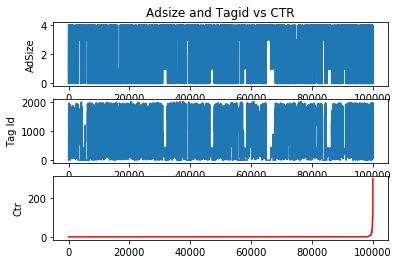

In [35]:
%matplotlib inline

plt.subplot(3,1,1)
plt.title('Adsize and Tagid vs CTR')
plt.plot(x,y[:,0])
plt.ylabel('AdSize')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Tag Id')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r') # 두번쨰 인자값은 그래스 스타일 : r = red color
plt.ylabel("Ctr")

plt.show()

##### 분석데이타 만들기

In [9]:
new_data = data[['timestamp','sdk_code','platform_code','pub_idx','pub_app_code','pub_tagid_code',
                       'shop_idx','campaign_group_idx',
                         'campaign_idx','ads_idx','adsize_code']]

X = new_data.values
y = data.ctr.values

In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [11]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[0.48530758 0.60608466 0.45615631 ... 0.64098009 0.34314718 0.63728486]


In [12]:
regr.score(X_test,y_test)

0.002229439964462787

In [13]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 5.73


Predicting

In [14]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [15]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [16]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

-30.74160574823279
